
# Цель - Подготовить основу рекомендательной системы.
### Если клиент кладёт в корзину курс, предложим ему ещё два курса, которые могли бы быть ему интересны
##### 1. Познакомиться с датасетом, подготовить и проанализировать данные с помощью SQL.
##### 2. Обработать данные средствами Python.
##### 3. Составить итоговую таблицу с рекомендациями, снабдив её необходимыми комментариями, и представить отчёт. 

In [10]:
# Импортируем библиотеки
import pandas as pd
import itertools
import numpy as np
from collections import Counter
import psycopg2.extras

In [11]:
# Пишем функцию с SQL-запросом чтобы загрузить только нужные данные из таблицы
def getRange():
    query = '''SELECT DISTINCT 
        user_id, 
        resource_id
    FROM final.carts c
    JOIN final.cart_items ci ON c.id = ci.cart_id
    WHERE 
    c.state = 'successful' AND ci.resource_type = 'Course'
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

In [12]:
# Создаём таблицу и смотрим что представляют из себя данные
total_sales = pd.DataFrame(getRange())
print(total_sales.head(10))

   user_id  resource_id
0   169821          679
1  1239932          745
2  1141426          504
3  1221330          566
4  1663432          566
5  1137633          571
6   992335         1129
7   645784          503
8   194020         1138
9  1131324          551


In [13]:
# Создаём сводную по пользователю и курсам, которые он купил
resource_by_user = total_sales.groupby('user_id')['resource_id']\
    .apply(lambda x: list(np.unique(x))).reset_index()
# Создаём список пар курсов и посмотрим, сколько из и сколько из них уникальных
list_courses = []
for resourse in resource_by_user['resource_id']:
    for pair in itertools.combinations(resourse, 2):
        list_courses.append(pair)
# Посмотрим количество уникальных пар курсов
print(len(set(list_courses)))

3989


In [14]:
# Посмотрим, какая пара наиоблее популярная, при помощи создания каунтера
counter_courses = Counter(list_courses)
print(counter_courses.most_common(1))

[((551, 566), 797)]


##### Найдём, какое значение количества покупок пары курсов считать слишком малым. 
Для этого обратимся к данным о парах курсов и количества покупок этой пары.
Ответим на вопрос: если покупают пару курсов, то какое медианное значение количества покупок пары?
Рассчитаем квартили и посмотрим, какое значение количества покупок пары считать выбросом

In [15]:
# Отбросим те значения, где пара покупалась 1 раз
pair_order = pair_order[pair_order['count_pairs'] > 1]
pair_order_median = pair_order['count_pairs'].median() # Рассчитали медиану
quartile_1 = pair_order[pair_order <= pair_order_median]['count_pairs'].median() # Рассчитали первый квартиль
quartile_3 = pair_order[pair_order >= pair_order_median]['count_pairs'].median() # Рассчитали третий квартиль
print('Медиана равна ', pair_order_median, '; нижний квартиль равен ', quartile_1, '; межквартильный размах равен ',
      quartile_3 - quartile_1)

Медиана равна  5.0 ; нижний квартиль равен  3.0 ; межквартильный размах равен  8.0


Для рассчёта того, какие значения следует считать выбросами, нужно отнять от нижнего квартиля межквартильный размах.
Мы видим, что в данном наборе данных ни одно значение, даже единицу, нельзя считать выбросом.
Чтобы проверить это дополнительно, построим круговую диаграмму и наглядно посмотрим, какое количество покупок пар курсов преобладает

<AxesSubplot:ylabel='count_pairs'>

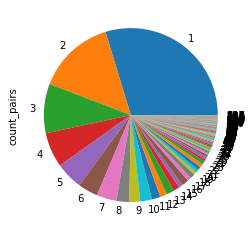

In [21]:
pair_order = pd.DataFrame({'count_pairs': list(counter_courses.values())})
grouped_pair = pair_order.groupby(by='count_pairs')['count_pairs'].count()
grouped_pair.plot(kind='pie')

Как видим из диаграммы, действительно более половины пар курсов заказывались в диапазоне 1-3 раза.
 
##### Мы не будем устанавливать значение, принимаемое за слишком малое.

##### Начинаем создание таблицы с рекомендациями

In [17]:
# Создаём список уникальных курсов
courses_unique = total_sales['resource_id'].unique()
# Создаём словарь из пар курсов и значений, сколько раз были покупки таких пар
dict_courses = dict(counter_courses)
# Также выделим 10 наименее популярных курсов для того, чтобы рекомендовать их в случае, если в полученных данных
# нет пары для каких-то курсов
pupular_courses = total_sales.groupby(by='resource_id')['resource_id'].count().sort_values()
not_popular_courses_1 = pupular_courses.index[0:5].tolist()
not_popular_courses_2 = pupular_courses.index[5:10].tolist()
# Выплоним сортировку словаря по номеру первого курса в паре
sorted_courses = {k: v for k, v in sorted(dict_courses.items(), key = lambda item: item[0], reverse=False)}

In [18]:
# Напишем функцию, которая создаёт список пар и частоты покупок этой пары, сортированный по убыванию частоты
def recomend(course):
    course_list = [] # Создаём пустой список
    for i in sorted_courses.keys(): # Идём по ключам сортированного словаря
        if i[0] == course: # Если первый курс в паре равен переданному номеру курса
            course_list.append((i, sorted_courses[i])) # Добавляем в список пару курсов и сколько раз 
            # купили эту пару
        if i[1] == course:  # Если второй курс в паре равен переданному номеру курса
            if sorted_courses[i] > 2:  # Если количество покупок этой пары курсов 3 и больше
                course_list.append(
                    ((i[1], i[0]), sorted_courses[i]))  # Добавляем в список пару курсов и сколько раз 
                # купили эту пару
        courses_list = sorted(course_list, key=lambda x: x[0], reverse=True)  # сортируем так, чтобы сверху 
        # были те пары, которые покупали наиболее часто
    return courses_list

#### Создадим итоговый Датафрейм
Индексами будут все уникальные курсы, а столбцами рекомендованные курсы. Сначала
будем предлагать рекомендацию по первому курсу в самой популярной паре, потом по второму
Если у курса нет нужного количества пар - предложим рандомный непопулярный курс

In [19]:
recomended_df = pd.DataFrame(columns=['rec_course_1', 'rec_course_2'])

for i in courses_unique:
    len_1 = len(recomend(i))
    if len_1 > 1:
        recomended_df.loc[i] = [recomend(i)[0][0][1], recomend(i)[1][0][1]]
    if len_1 == 1:
        recomended_df.loc[i] = [recomend(i)[0][0][1], np.random.choice(not_popular_courses_1)]
    if len_1 == 0:
        recomended_df.loc[i] = [np.random.choice(not_popular_courses_1), np.random.choice(not_popular_courses_2)]

print(recomended_df.head(20))

     rec_course_1 rec_course_2
679          1185         1184
745          1198         1188
504          1161         1147
566          1188         1187
571          1201         1198
1129         1161         1156
503          1188         1185
1138         1187         1156
551          1198         1188
356          1198         1187
514          1188         1187
523          1199         1198
1152         1160         1115
366          1198         1188
490          1186         1181
1181         1184         1115
511          1161         1160
840          1186         1184
794          1200         1187
572          1161         1156


### ИТОГ:
##### 1. Создан итоговый датафрейм с рекомендациями
##### 2. В начале мы предлагаем курсы, которые были самыми популярными при совместных покупках
##### 3. Если к курсу не нашлось одной или обеих пар, мы предлагаем рандомный курс из первых двух пятёрок самых непопулярных курсов, чтобы увеличить их продажи